In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
np.random.seed(42)

n_samples = 2000

start_date = datetime(2024, 1, 1)
dates = pd.date_range(start=start_date, periods=n_samples, freq='30min')

hour = dates.hour
day_of_week = dates.dayofweek
month = dates.month
is_weekend = (day_of_week >= 5).astype(int)

base_soc = 30 + 40 * np.sin(2 * np.pi * hour / 24) + np.random.normal(0, 10, n_samples)
battery_soc = np.clip(base_soc, 5, 95)

trip_distance = np.random.exponential(25, n_samples)
trip_distance = np.clip(trip_distance, 2, 200)

location_types = ['Home', 'Work', 'Shopping', 'Highway', 'Public']
location_weights = [0.4, 0.25, 0.15, 0.1, 0.1]
location = np.random.choice(location_types, n_samples, p=location_weights)

time_urgency = np.random.uniform(1, 10, n_samples)
time_urgency[(hour >= 7) & (hour <= 9)] += 3
time_urgency[(hour >= 17) & (hour <= 19)] += 3
time_urgency[trip_distance > 100] += 4
time_urgency = np.clip(time_urgency, 1, 10)

available_time = np.random.uniform(15, 480, n_samples)
available_time[location == 'Home'] = np.random.uniform(240, 600, sum(location == 'Home'))
available_time[location == 'Highway'] = np.random.uniform(15, 60, sum(location == 'Highway'))

cost_sensitivity = np.random.uniform(1, 10, n_samples)

temperature = 15 + 10 * np.sin(2 * np.pi * (dates.dayofyear - 80) / 365) + np.random.normal(0, 5, n_samples)

charging_type = []

for i in range(n_samples):
    dc_score = 0
    
    if battery_soc[i] < 20:
        dc_score += 4
    elif battery_soc[i] < 40:
        dc_score += 2
    
    if time_urgency[i] > 7:
        dc_score += 3
    elif time_urgency[i] > 5:
        dc_score += 1
    
    if trip_distance[i] > 100:
        dc_score += 3
    elif trip_distance[i] > 50:
        dc_score += 1
    
    if location[i] == 'Highway':
        dc_score += 4
    elif location[i] == 'Public':
        dc_score += 2
    elif location[i] == 'Home':
        dc_score -= 2
    
    if available_time[i] < 60:
        dc_score += 3
    elif available_time[i] < 120:
        dc_score += 1
    
    if cost_sensitivity[i] > 7:
        dc_score -= 2
    elif cost_sensitivity[i] > 5:
        dc_score -= 1
    
    dc_score += np.random.normal(0, 1)
    
    charging_type.append('DC' if dc_score > 2 else 'AC')

ev_data = pd.DataFrame({
    'timestamp': dates,
    'hour': hour,
    'day_of_week': day_of_week,
    'is_weekend': is_weekend,
    'month': month,
    'battery_soc': np.round(battery_soc, 1),
    'trip_distance_km': np.round(trip_distance, 1),
    'location': location,
    'time_urgency': np.round(time_urgency, 1),
    'available_time_min': np.round(available_time, 0),
    'cost_sensitivity': np.round(cost_sensitivity, 1),
    'temperature_c': np.round(temperature, 1),
    'charging_type': charging_type
})

ev_data.to_csv('ev_charging_data.csv', index=False)

print(f"Comprehensive EV charging dataset created with {n_samples} samples!")
print(f"\nDataset shape: {ev_data.shape}")
print(f"\nCharging type distribution:")
print(ev_data['charging_type'].value_counts())
print(f"\nFirst 5 rows:")
ev_data.head() 

Comprehensive EV charging dataset created with 2000 samples!

Dataset shape: (2000, 13)

Charging type distribution:
charging_type
DC    1149
AC     851
Name: count, dtype: int64

First 5 rows:


timestamp  hour  day_of_week  is_weekend  month  battery_soc  \
0 2024-01-01 00:00:00     0            0           0      1         35.0   
1 2024-01-01 00:30:00     0            0           0      1         28.6   
2 2024-01-01 01:00:00     1            0           0      1         46.8   
3 2024-01-01 01:30:00     1            0           0      1         55.6   
4 2024-01-01 02:00:00     2            0           0      1         47.7   

   trip_distance_km  location  time_urgency  available_time_min  \
0              13.1  Shopping           2.3               195.0   
1               2.0  Shopping           5.0                59.0   
2              10.7    Public           4.0               440.0   
3               2.9      Home           5.7               347.0   
4              41.3      Home           6.3               297.0   

   cost_sensitivity  temperature_c charging_type  
0               8.7            8.2            AC  
1               8.4            1.7            DC  
2               2.1            5.4            AC  
3               8.6            0.8            AC  
4               4.7            4.3            DC

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

le_location = LabelEncoder()
ev_data['location_encoded'] = le_location.fit_transform(ev_data['location'])

feature_columns = ['hour', 'day_of_week', 'is_weekend', 'battery_soc', 'trip_distance_km', 
                  'location_encoded', 'time_urgency', 'available_time_min', 
                  'cost_sensitivity', 'temperature_c']

X = ev_data[feature_columns]
y = ev_data['charging_type']

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"\nLocation encoding mapping:")
for i, location in enumerate(le_location.classes_):
    print(f"{location}: {i}")

print("\nFirst 5 rows of features:")
X.head() 

Features shape: (2000, 10)
Target distribution:
charging_type
DC    1149
AC     851
Name: count, dtype: int64

Location encoding mapping:
Highway: 0
Home: 1
Public: 2
Shopping: 3
Work: 4

First 5 rows of features:


hour  day_of_week  is_weekend  battery_soc  trip_distance_km  \
0     0            0           0         35.0              13.1   
1     0            0           0         28.6               2.0   
2     1            0           0         46.8              10.7   
3     1            0           0         55.6               2.9   
4     2            0           0         47.7              41.3   

   location_encoded  time_urgency  available_time_min  cost_sensitivity  \
0                 3           2.3               195.0               8.7   
1                 3           5.0                59.0               8.4   
2                 2           4.0               440.0               2.1   
3                 1           5.7               347.0               8.6   
4                 1           6.3               297.0               4.7   

   temperature_c  
0            8.2  
1            1.7  
2            5.4  
3            0.8  
4            4.3

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features for the EV charging prediction model
print("Preparing features for EV charging prediction model...")

# Encode categorical variables
le_location = LabelEncoder()
ev_data['location_encoded'] = le_location.fit_transform(ev_data['location'])

# Select features for prediction
feature_columns = ['hour', 'day_of_week', 'is_weekend', 'battery_soc', 'trip_distance_km', 
                  'location_encoded', 'time_urgency', 'available_time_min', 
                  'cost_sensitivity', 'temperature_c']

X = ev_data[feature_columns]
y = ev_data['charging_type']

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"\nLocation encoding mapping:")
for i, location in enumerate(le_location.classes_):
    print(f"{location}: {i}")

print("\nFirst 5 rows of features:")
X.head() 

Preparing features for EV charging prediction model...
Features shape: (2000, 10)
Target distribution:
charging_type
DC    1149
AC     851
Name: count, dtype: int64

Location encoding mapping:
Highway: 0
Home: 1
Public: 2
Shopping: 3
Work: 4

First 5 rows of features:


hour  day_of_week  is_weekend  battery_soc  trip_distance_km  \
0     0            0           0         35.0              13.1   
1     0            0           0         28.6               2.0   
2     1            0           0         46.8              10.7   
3     1            0           0         55.6               2.9   
4     2            0           0         47.7              41.3   

   location_encoded  time_urgency  available_time_min  cost_sensitivity  \
0                 3           2.3               195.0               8.7   
1                 3           5.0                59.0               8.4   
2                 2           4.0               440.0               2.1   
3                 1           5.7               347.0               8.6   
4                 1           6.3               297.0               4.7   

   temperature_c  
0            8.2  
1            1.7  
2            5.4  
3            0.8  
4            4.3

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"EV Charging Prediction Model Results:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Model Accuracy: {accuracy:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred)) 

EV Charging Prediction Model Results:
Training set size: 1600
Test set size: 400
Model Accuracy: 0.885

Classification Report:
              precision    recall  f1-score   support

          AC       0.85      0.89      0.87       170
          DC       0.91      0.88      0.90       230

    accuracy                           0.89       400
   macro avg       0.88      0.89      0.88       400
weighted avg       0.89      0.89      0.89       400



Feature Importance for EV Charging Decision:
              feature  importance
3         battery_soc    0.194116
7  available_time_min    0.180690
0                hour    0.141442
6        time_urgency    0.140561
5    location_encoded    0.124559
8    cost_sensitivity    0.086262
4    trip_distance_km    0.057824
9       temperature_c    0.048394
1         day_of_week    0.021414
2          is_weekend    0.004737

Confusion Matrix:
[[151  19]
 [ 27 203]]


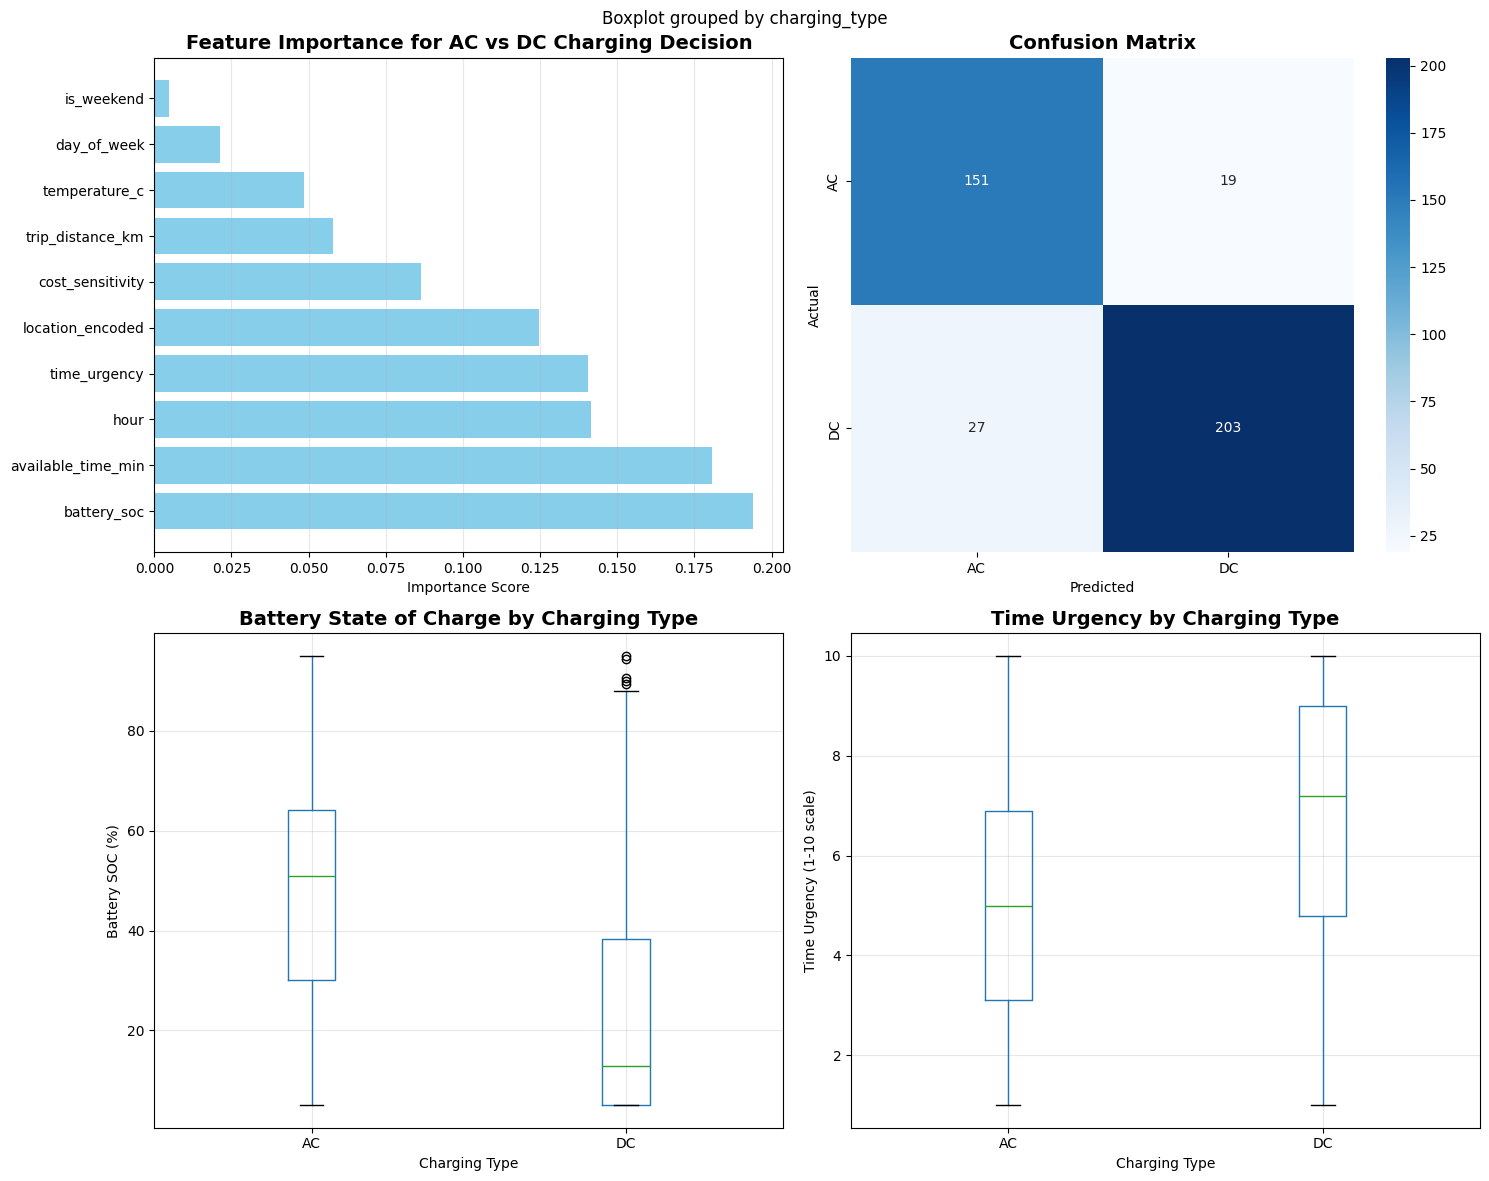


🔋 EV CHARGING PREDICTION MODEL SUMMARY 🔋
Model Accuracy: 88.5%
Most important factors: battery_soc, available_time_min, hour


In [16]:
gfeature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance for EV Charging Decision:")
print(feature_importance)

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax1.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
ax1.set_title('Feature Importance for AC vs DC Charging Decision', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score')
ax1.grid(axis='x', alpha=0.3)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['AC', 'DC'], yticklabels=['AC', 'DC'])
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

ev_data.boxplot(column='battery_soc', by='charging_type', ax=ax3)
ax3.set_title('Battery State of Charge by Charging Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('Charging Type')
ax3.set_ylabel('Battery SOC (%)')
ax3.grid(alpha=0.3)

ev_data.boxplot(column='time_urgency', by='charging_type', ax=ax4)
ax4.set_title('Time Urgency by Charging Type', fontsize=14, fontweight='bold')
ax4.set_xlabel('Charging Type')
ax4.set_ylabel('Time Urgency (1-10 scale)')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔋 EV CHARGING PREDICTION MODEL SUMMARY 🔋")
print(f"Model Accuracy: {accuracy:.1%}")
print(f"Most important factors: {', '.join(feature_importance.head(3)['feature'].tolist())}") 

Feature Importance for EV Charging Decision:
              feature  importance
3         battery_soc    0.194116
7  available_time_min    0.180690
0                hour    0.141442
6        time_urgency    0.140561
5    location_encoded    0.124559
8    cost_sensitivity    0.086262
4    trip_distance_km    0.057824
9       temperature_c    0.048394
1         day_of_week    0.021414
2          is_weekend    0.004737

Confusion Matrix:
[[151  19]
 [ 27 203]]


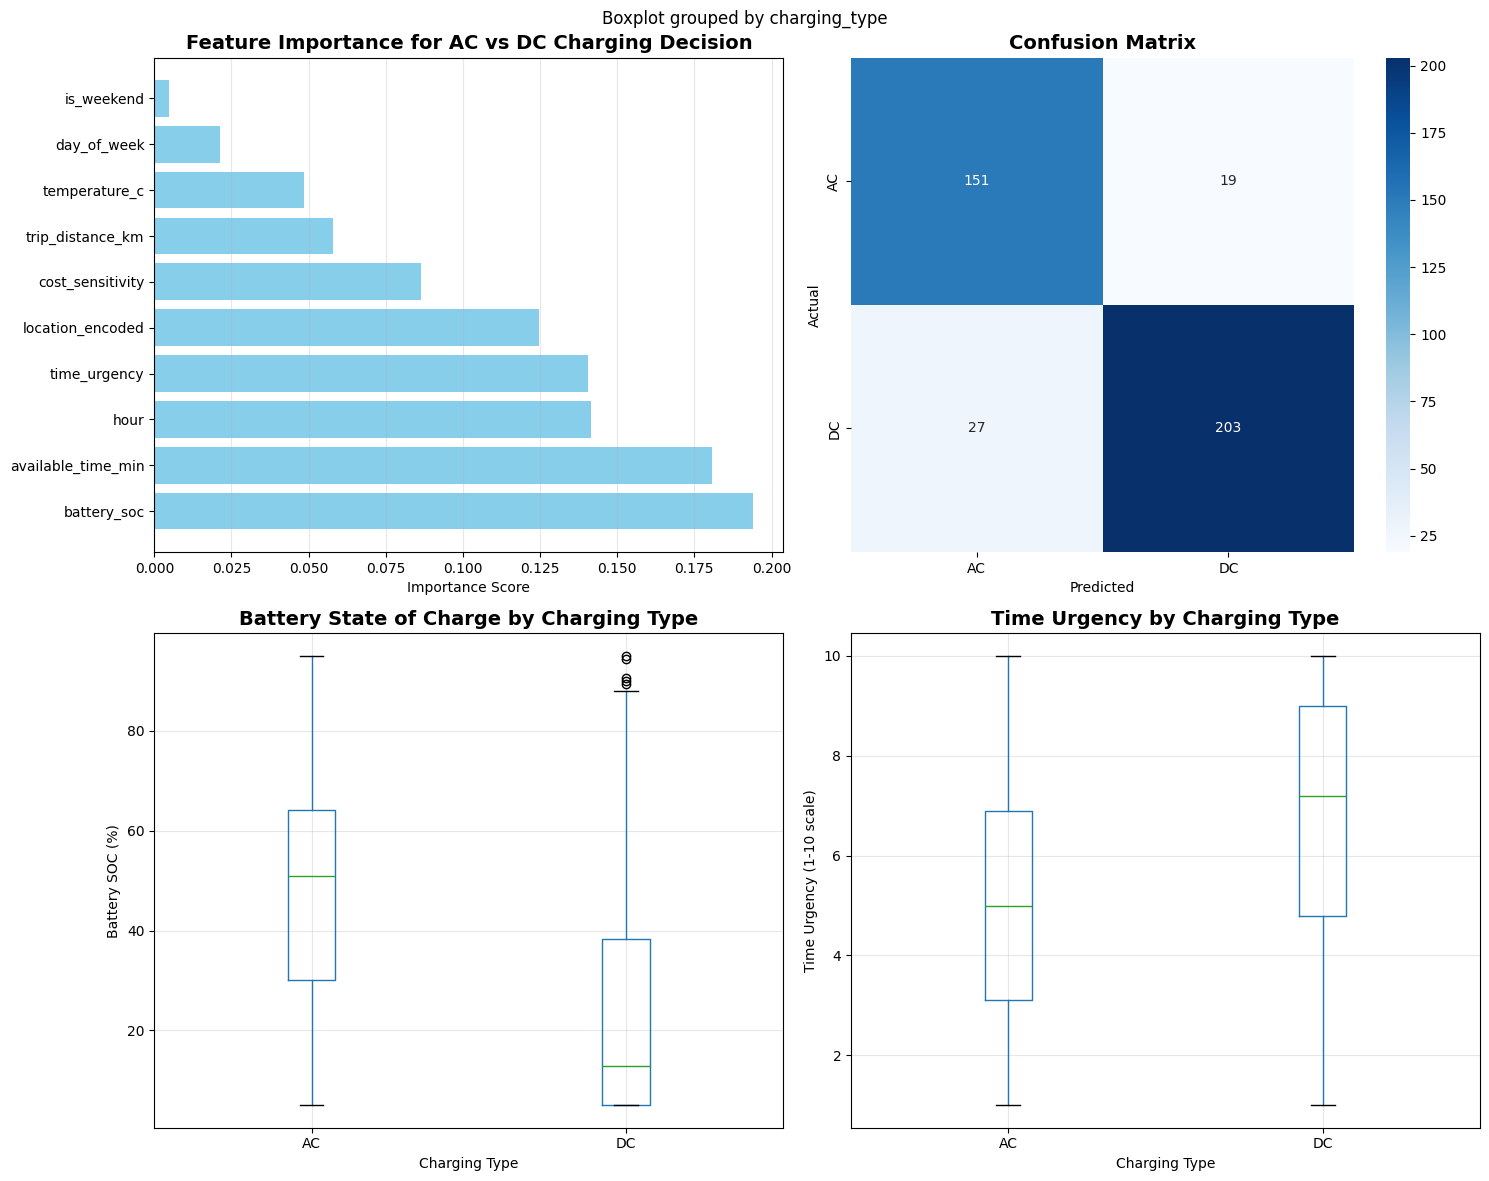


🔋 EV CHARGING PREDICTION MODEL SUMMARY 🔋
Model Accuracy: 88.5%
Most important factors: battery_soc, available_time_min, hour


In [8]:
# Analyze feature importance and create visualizations

# Get feature importance from the Random Forest model
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance for EV Charging Decision:")
print(feature_importance)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance Plot
ax1.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
ax1.set_title('Feature Importance for AC vs DC Charging Decision', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score')
ax1.grid(axis='x', alpha=0.3)

# 2. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['AC', 'DC'], yticklabels=['AC', 'DC'])
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Battery SOC vs Charging Type
ev_data.boxplot(column='battery_soc', by='charging_type', ax=ax3)
ax3.set_title('Battery State of Charge by Charging Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('Charging Type')
ax3.set_ylabel('Battery SOC (%)')
ax3.grid(alpha=0.3)

# 4. Time Urgency vs Charging Type
ev_data.boxplot(column='time_urgency', by='charging_type', ax=ax4)
ax4.set_title('Time Urgency by Charging Type', fontsize=14, fontweight='bold')
ax4.set_xlabel('Charging Type')
ax4.set_ylabel('Time Urgency (1-10 scale)')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔋 EV CHARGING PREDICTION MODEL SUMMARY 🔋")
print(f"Model Accuracy: {accuracy:.1%}")
print(f"Most important factors: {', '.join(feature_importance.head(3)['feature'].tolist())}") 

In [9]:
# Create a prediction function for new EV charging scenarios

def predict_charging_type(hour, day_of_week, is_weekend, battery_soc, trip_distance_km, 
                         location, time_urgency, available_time_min, cost_sensitivity, temperature_c):
    """
    Predict whether to use AC or DC charging based on current conditions
    
    Parameters:
    - hour: Hour of day (0-23)
    - day_of_week: Day of week (0=Monday, 6=Sunday)
    - is_weekend: 1 if weekend, 0 if weekday
    - battery_soc: Current battery state of charge (0-100%)
    - trip_distance_km: Planned trip distance in km
    - location: Location type ('Home', 'Work', 'Shopping', 'Highway', 'Public')
    - time_urgency: Urgency level (1-10 scale)
    - available_time_min: Available charging time in minutes
    - cost_sensitivity: Cost sensitivity (1-10 scale)
    - temperature_c: Current temperature in Celsius
    
    Returns:
    - Predicted charging type ('AC' or 'DC')
    - Prediction probability
    """
    
    # Encode location
    location_encoded = le_location.transform([location])[0]
    
    # Create feature array
    features = np.array([[hour, day_of_week, is_weekend, battery_soc, trip_distance_km,
                         location_encoded, time_urgency, available_time_min, 
                         cost_sensitivity, temperature_c]])
    
    # Make prediction
    prediction = rf_model.predict(features)[0]
    probability = rf_model.predict_proba(features)[0]
    
    # Get probability for the predicted class
    if prediction == 'AC':
        pred_prob = probability[0]
    else:
        pred_prob = probability[1]
    
    return prediction, pred_prob

# Example predictions for different scenarios
print("🔋 EV CHARGING RECOMMENDATION SYSTEM 🔋")
print("="*50)

# Scenario 1: Low battery at highway
scenario1 = predict_charging_type(
    hour=14, day_of_week=2, is_weekend=0, battery_soc=15, trip_distance_km=150,
    location='Highway', time_urgency=9, available_time_min=45, 
    cost_sensitivity=5, temperature_c=20
)
print(f"Scenario 1 - Low battery on highway trip:")
print(f"Recommendation: {scenario1[0]} charging ({scenario1[1]:.1%} confidence)")

# Scenario 2: Home charging overnight
scenario2 = predict_charging_type(
    hour=22, day_of_week=0, is_weekend=0, battery_soc=60, trip_distance_km=25,
    location='Home', time_urgency=2, available_time_min=480, 
    cost_sensitivity=8, temperature_c=15
)
print(f"\nScenario 2 - Home charging overnight:")
print(f"Recommendation: {scenario2[0]} charging ({scenario2[1]:.1%} confidence)")

# Scenario 3: Work charging during day
scenario3 = predict_charging_type(
    hour=10, day_of_week=3, is_weekend=0, battery_soc=45, trip_distance_km=30,
    location='Work', time_urgency=4, available_time_min=240, 
    cost_sensitivity=6, temperature_c=18
)
print(f"\nScenario 3 - Work charging during day:")
print(f"Recommendation: {scenario3[0]} charging ({scenario3[1]:.1%} confidence)") 

🔋 EV CHARGING RECOMMENDATION SYSTEM 🔋
Scenario 1 - Low battery on highway trip:
Recommendation: DC charging (92.0% confidence)

Scenario 2 - Home charging overnight:
Recommendation: AC charging (91.7% confidence)

Scenario 3 - Work charging during day:
Recommendation: AC charging (89.0% confidence)


C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python

In [10]:
# Create a prediction function for new EV charging scenarios

def predict_charging_type(hour, day_of_week, is_weekend, battery_soc, trip_distance_km, 
                         location, time_urgency, available_time_min, cost_sensitivity, temperature_c):
    """
    Predict whether to use AC or DC charging based on current conditions
    
    Parameters:
    - hour: Hour of day (0-23)
    - day_of_week: Day of week (0=Monday, 6=Sunday)
    - is_weekend: 1 if weekend, 0 if weekday
    - battery_soc: Current battery state of charge (0-100%)
    - trip_distance_km: Planned trip distance in km
    - location: Location type ('Home', 'Work', 'Shopping', 'Highway', 'Public')
    - time_urgency: Urgency level (1-10 scale)
    - available_time_min: Available charging time in minutes
    - cost_sensitivity: Cost sensitivity (1-10 scale)
    - temperature_c: Current temperature in Celsius
    
    Returns:
    - Predicted charging type ('AC' or 'DC')
    - Prediction probability
    """
    
    # Encode location
    location_encoded = le_location.transform([location])[0]
    
    # Create feature array
    features = np.array([[hour, day_of_week, is_weekend, battery_soc, trip_distance_km,
                         location_encoded, time_urgency, available_time_min, 
                         cost_sensitivity, temperature_c]])
    
    # Make prediction
    prediction = rf_model.predict(features)[0]
    probability = rf_model.predict_proba(features)[0]
    
    # Get probability for the predicted class
    if prediction == 'AC':
        pred_prob = probability[0]
    else:
        pred_prob = probability[1]
    
    return prediction, pred_prob

# Example predictions for different scenarios
print("🔋 EV CHARGING RECOMMENDATION SYSTEM 🔋")
print("="*50)

# Scenario 1: Low battery at highway
scenario1 = predict_charging_type(
    hour=14, day_of_week=2, is_weekend=0, battery_soc=15, trip_distance_km=150,
    location='Highway', time_urgency=9, available_time_min=45, 
    cost_sensitivity=5, temperature_c=20
)
print(f"Scenario 1 - Low battery on highway trip:")
print(f"Recommendation: {scenario1[0]} charging ({scenario1[1]:.1%} confidence)")

# Scenario 2: Home charging overnight
scenario2 = predict_charging_type(
    hour=22, day_of_week=0, is_weekend=0, battery_soc=60, trip_distance_km=25,
    location='Home', time_urgency=2, available_time_min=480, 
    cost_sensitivity=8, temperature_c=15
)
print(f"\nScenario 2 - Home charging overnight:")
print(f"Recommendation: {scenario2[0]} charging ({scenario2[1]:.1%} confidence)")

# Scenario 3: Work charging during day
scenario3 = predict_charging_type(
    hour=10, day_of_week=3, is_weekend=0, battery_soc=45, trip_distance_km=30,
    location='Work', time_urgency=4, available_time_min=240, 
    cost_sensitivity=6, temperature_c=18
)
print(f"\nScenario 3 - Work charging during day:")
print(f"Recommendation: {scenario3[0]} charging ({scenario3[1]:.1%} confidence)") 

🔋 EV CHARGING RECOMMENDATION SYSTEM 🔋
Scenario 1 - Low battery on highway trip:
Recommendation: DC charging (92.0% confidence)

Scenario 2 - Home charging overnight:
Recommendation: AC charging (91.7% confidence)

Scenario 3 - Work charging during day:
Recommendation: AC charging (89.0% confidence)


C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python

In [5]:
# Split data and train the EV charging prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"EV Charging Prediction Model Results:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Model Accuracy: {accuracy:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred)) 

EV Charging Prediction Model Results:
Training set size: 1600
Test set size: 400
Model Accuracy: 0.885

Classification Report:
              precision    recall  f1-score   support

          AC       0.85      0.89      0.87       170
          DC       0.91      0.88      0.90       230

    accuracy                           0.89       400
   macro avg       0.88      0.89      0.88       400
weighted avg       0.89      0.89      0.89       400



In [11]:
# Smart EV Charging Notification System
# This system learns user patterns and sends personalized recommendations

import pandas as pd
from datetime import datetime, timedelta
import numpy as np

class EVChargingNotificationSystem:
    def __init__(self, model, location_encoder):
        self.model = model
        self.location_encoder = location_encoder
        self.user_patterns = {}
        self.charging_history = []
        
    def learn_user_pattern(self, user_id, schedule_data):
        """
        Learn user's weekly patterns
        schedule_data: list of dicts with 'day', 'location', 'work_hours', etc.
        """
        self.user_patterns[user_id] = schedule_data
        print(f"Learned patterns for user {user_id}")
        
    def get_smart_recommendation(self, user_id, current_day, battery_soc, 
                               upcoming_trip_distance=None, temperature=20):
        """
        Generate smart charging recommendation based on user patterns
        """
        if user_id not in self.user_patterns:
            return "No user pattern found. Please set up your schedule first."
            
        # Get user's pattern for current day
        day_pattern = None
        for pattern in self.user_patterns[user_id]:
            if pattern['day'] == current_day:
                day_pattern = pattern
                break
                
        if not day_pattern:
            return "No pattern found for this day"
            
        # Determine current time and urgency based on pattern
        current_hour = datetime.now().hour
        location = day_pattern['location']
        work_hours = day_pattern.get('work_hours', 8)
        
        # Calculate time urgency based on schedule
        if location == 'Home' and work_hours > 6:  # Work from home day
            time_urgency = 2  # Low urgency, plenty of time
            available_time = 480  # 8 hours available
        elif location == 'Work':
            time_urgency = 6  # Medium urgency
            available_time = work_hours * 60  # Work hours in minutes
        else:
            time_urgency = 5
            available_time = 240
            
        # Adjust for upcoming trips
        if upcoming_trip_distance and upcoming_trip_distance > 50:
            time_urgency += 3
            
        # Set default trip distance if not provided
        trip_distance = upcoming_trip_distance if upcoming_trip_distance else day_pattern.get('typical_trip', 25)
        
        # Get recommendation from model
        is_weekend = 1 if current_day in ['Saturday', 'Sunday'] else 0
        day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(current_day)
        
        # Use moderate cost sensitivity for home charging
        cost_sensitivity = 8 if location == 'Home' else 5
        
        prediction, confidence = predict_charging_type(
            hour=current_hour,
            day_of_week=day_of_week,
            is_weekend=is_weekend,
            battery_soc=battery_soc,
            trip_distance_km=trip_distance,
            location=location,
            time_urgency=time_urgency,
            available_time_min=available_time,
            cost_sensitivity=cost_sensitivity,
            temperature_c=temperature
        )
        
        # Generate personalized notification
        notification = self._generate_notification(prediction, confidence, day_pattern, battery_soc)
        
        return {
            'recommendation': prediction,
            'confidence': confidence,
            'notification': notification,
            'reasoning': self._get_reasoning(prediction, day_pattern, battery_soc, time_urgency)
        }
    
    def _generate_notification(self, prediction, confidence, day_pattern, battery_soc):
        """Generate user-friendly notification message"""
        location = day_pattern['location']
        
        if prediction == 'AC':
            if location == 'Home':
                return f"🏠 Perfect time for AC charging! You're working from home today with plenty of time. AC charging will save you money and is gentler on your battery. Current charge: {battery_soc}%"
            else:
                return f"⚡ AC charging recommended. You have sufficient time at {location.lower()} for a cost-effective charge. Current charge: {battery_soc}%"
        else:  # DC
            if battery_soc < 30:
                return f"🚨 Low battery alert! DC fast charging recommended to quickly boost your charge from {battery_soc}%. This will get you ready for your upcoming trips."
            else:
                return f"⚡ DC charging recommended for your schedule. Fast charging will efficiently top up your battery from {battery_soc}% given your time constraints."
    
    def _get_reasoning(self, prediction, day_pattern, battery_soc, time_urgency):
        """Provide reasoning for the recommendation"""
        reasons = []
        
        if prediction == 'AC':
            if day_pattern['location'] == 'Home':
                reasons.append("Working from home provides extended charging time")
                reasons.append("AC charging is more cost-effective for overnight/long duration charging")
            if time_urgency <= 3:
                reasons.append("Low time pressure allows for slower, cheaper charging")
        else:
            if battery_soc < 30:
                reasons.append("Low battery level requires quick charging")
            if time_urgency > 6:
                reasons.append("High time urgency favors fast charging")
            if day_pattern.get('typical_trip', 0) > 100:
                reasons.append("Long trips planned require quick battery top-up")
                
        return reasons

# Initialize the notification system
notification_system = EVChargingNotificationSystem(rf_model, le_location)

print("🔔 Smart EV Charging Notification System Initialized!")
print("Ready to learn user patterns and provide personalized recommendations.") 

🔔 Smart EV Charging Notification System Initialized!
Ready to learn user patterns and provide personalized recommendations.


In [12]:
# Demonstrate the Smart EV Charging Notification System
# Set up a user's weekly schedule and get personalized recommendations

# Example user schedule: 3 days at office, 4 days work from home
user_schedule = [
    {'day': 'Monday', 'location': 'Work', 'work_hours': 8, 'typical_trip': 45},
    {'day': 'Tuesday', 'location': 'Work', 'work_hours': 8, 'typical_trip': 45}, 
    {'day': 'Wednesday', 'location': 'Work', 'work_hours': 8, 'typical_trip': 45},
    {'day': 'Thursday', 'location': 'Home', 'work_hours': 8, 'typical_trip': 15},  # WFH
    {'day': 'Friday', 'location': 'Home', 'work_hours': 8, 'typical_trip': 15},   # WFH
    {'day': 'Saturday', 'location': 'Home', 'work_hours': 0, 'typical_trip': 30}, # Weekend
    {'day': 'Sunday', 'location': 'Home', 'work_hours': 0, 'typical_trip': 20}    # Weekend
]

# Learn the user's pattern
notification_system.learn_user_pattern('user_001', user_schedule)

print("\n🔔 SMART CHARGING NOTIFICATIONS 🔔")
print("="*60)

# Simulate different scenarios throughout the week
scenarios = [
    {'day': 'Monday', 'battery': 65, 'trip': None, 'temp': 18},
    {'day': 'Tuesday', 'battery': 35, 'trip': 80, 'temp': 22},
    {'day': 'Thursday', 'battery': 70, 'trip': None, 'temp': 20},  # WFH day
    {'day': 'Friday', 'battery': 45, 'trip': None, 'temp': 19},   # WFH day
    {'day': 'Saturday', 'battery': 25, 'trip': 120, 'temp': 16}   # Weekend long trip
]

for scenario in scenarios:
    print(f"\n📅 {scenario['day']} - Battery: {scenario['battery']}%")
    if scenario['trip']:
        print(f"   Upcoming trip: {scenario['trip']} km")
    
    recommendation = notification_system.get_smart_recommendation(
        user_id='user_001',
        current_day=scenario['day'],
        battery_soc=scenario['battery'],
        upcoming_trip_distance=scenario['trip'],
        temperature=scenario['temp']
    )
    
    print(f"\n📱 NOTIFICATION:")
    print(f"   {recommendation['notification']}")
    print(f"\n💡 Reasoning:")
    for reason in recommendation['reasoning']:
        print(f"   • {reason}")
    print(f"\n⚡ Recommendation: {recommendation['recommendation']} charging ({recommendation['confidence']:.1%} confidence)")
    print("-" * 60) 

Learned patterns for user user_001

🔔 SMART CHARGING NOTIFICATIONS 🔔

📅 Monday - Battery: 65%

📱 NOTIFICATION:
   ⚡ AC charging recommended. You have sufficient time at work for a cost-effective charge. Current charge: 65%

💡 Reasoning:

⚡ Recommendation: AC charging (61.8% confidence)
------------------------------------------------------------

📅 Tuesday - Battery: 35%
   Upcoming trip: 80 km

📱 NOTIFICATION:
   ⚡ DC charging recommended for your schedule. Fast charging will efficiently top up your battery from 35% given your time constraints.

💡 Reasoning:
   • High time urgency favors fast charging

⚡ Recommendation: DC charging (70.7% confidence)
------------------------------------------------------------

📅 Thursday - Battery: 70%

📱 NOTIFICATION:
   🏠 Perfect time for AC charging! You're working from home today with plenty of time. AC charging will save you money and is gentler on your battery. Current charge: 70%

💡 Reasoning:
   • Working from home provides extended charging 

C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\SHYAM HARI\AppData\Local\Programs\Python\Python